In [1]:
from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp
     
import torch as t
from transformer_lens.utils import to_numpy
import plotly.express as px
import pprint
import pandas as pd
import matplotlib.pyplot as plt


import importlib

def reload_fuctions():
    '''
    Reloads the functions from the utils package. 
    This is useful when you are working on the functions 
    and want to see the changes without restarting the kernel.'''
    import utils

    importlib.reload(utils.data)
    importlib.reload(utils.model)
    importlib.reload(utils.plotting)

    globals().update({name: getattr(utils.data, name) for name in dir(utils.data)})
    globals().update({name: getattr(utils.model, name) for name in dir(utils.model)})
    globals().update({name: getattr(utils.plotting, name) for name in dir(utils.plotting)})

    

from utils.data import *
from utils.model import *
from utils.plotting import *

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'bwr'
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

# Tracr sorting model
It translates the inputs into unique keys and sort them using unique sort. which is implemented like this:
```python

```

In [2]:
input_size = 10
vocab = {*range(input_size)}
program = lib.make_sort(rasp.tokens, rasp.tokens, max_seq_len=input_size, min_key=0)

assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=input_size,
      compiler_bos="bos",
      mlp_exactness=100)

INPUT_ENCODER = assembled_model.input_encoder
OUTPUT_ENCODER = assembled_model.output_encoder

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Tracr model Config
After compling we see that the model has 2 layers, which is less that the maximum sequence length, meaning that the model is able to sort sequences longer than it's model length

In [3]:
pprint.pprint(assembled_model.model_config)

TransformerConfig(num_heads=1,
                  num_layers=3,
                  key_size=12,
                  mlp_hidden_size=100,
                  dropout_rate=0.0,
                  activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x7fcf8031d5d0>,
                  layer_norm=False,
                  causal=False)


In [3]:
reload_fuctions()
TRAIN = False

cfg = cfg_from_tracr(assembled_model)
model = HookedTransformer(cfg)
model_mid_decay = HookedTransformer(cfg)
model_high_decay = HookedTransformer(cfg)
tr_model = HookedTransformer(cfg)
tr_model = load_tracr_weights(tr_model, assembled_model, cfg)
criterion = transformers_cross_entropy
decays = [0, 0.0001, 0.001]
labels = ['no_decay', 'mid_decay', 'high_decay']

models =[model, model_mid_decay, model_high_decay]
name_dict = {lamb: label for lamb, label in zip(decays, labels)} 
lr=.001
m_losses = []
m_accuracies = []
m_metrics = []

if TRAIN:
    epochs = 300
    batch_size = 256
    for penalty in [l1_pentaly_activation]:
        for lamb,m in zip(decays, models):
            optimizer = t.optim.AdamW(m.parameters(), lr=lr)

            

            
            
            save_path = f'models/sort_{name_dict[lamb]}_l1_activation.pth' 
            print(save_path)

            losses, accuracy, metrics = train_model(m, optimizer, criterion, penalty(lamb), train_loader, epochs, batch_size, input_size, len(vocab), test_benchmarks, save_path)
            m_losses.append(losses)
            m_accuracies.append(accuracy)
            m_metrics.append(metrics)
        

save_paths = [f'models/sort_{name_dict[lamb]}_l1_activation.pth' for lamb in decays]

for m, save_path in zip([model, model_mid_decay, model_high_decay], save_paths):
    print(save_path)
    m.load_state_dict(t.load(save_path), strict=True)

models/sort_no_decay_l1_activation.pth
models/sort_mid_decay_l1_activation.pth
models/sort_high_decay_l1_activation.pth


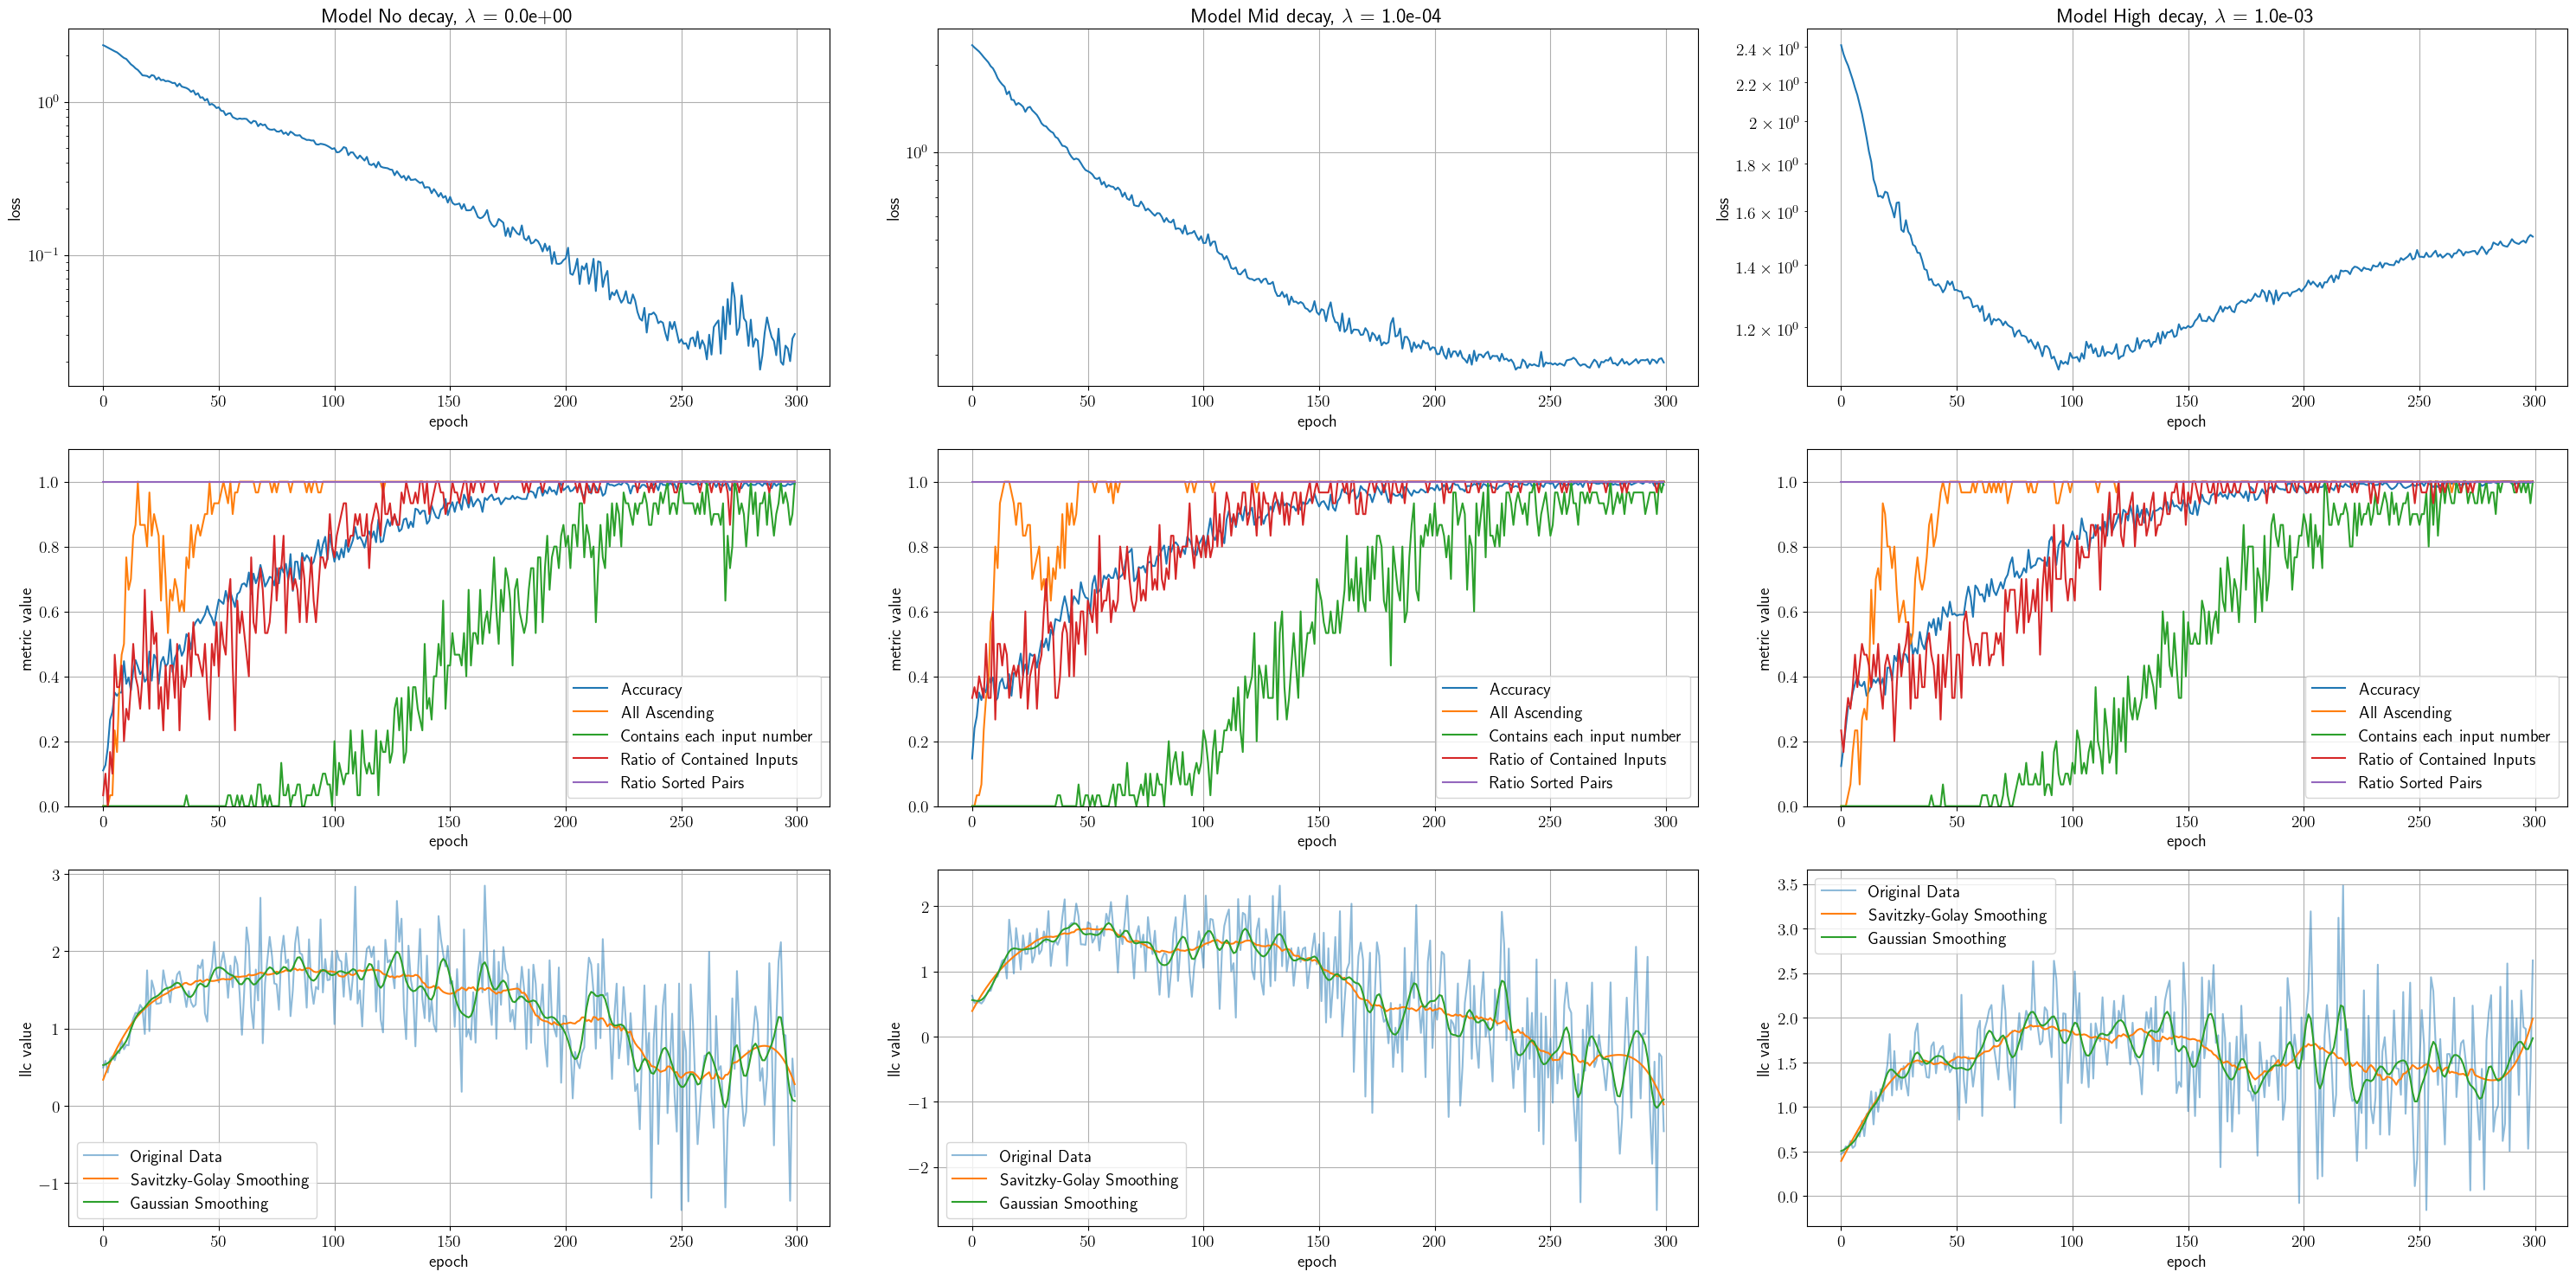

In [4]:
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

metric_labels = ['Accuracy', 'All Ascending', 'Contains each input number', 'Ratio of Contained Inputs', 'Ratio Sorted Pairs']

if TRAIN:
    data = np.empty((len(decays), 1+len(metric_labels), epochs))
    data[:, 0, :] = np.array(m_losses)
    data[:, 1, :] = np.array(m_accuracies)
    data[:, 2:, :] = np.array(m_metrics)
    np.save('metrics.npy', data)
else:
    data = np.load('metrics.npy')

llc_vals = pd.read_csv('llc_values.csv')
llc_vals['decay'] = llc_vals['model'].apply(lambda x: x.split('_')[1])
llc_vals['epoch'] = llc_vals['model'].apply(lambda x: int(x.split('_')[-1].split('.')[0]))

# plot llc values for difference decay in the same figure
llc = [ llc_vals[llc_vals['decay'] == 'no'],
        llc_vals[llc_vals['decay'] == 'mid'], 
        llc_vals[llc_vals['decay'] == 'high']]


fig, axes = plt.subplots(3, 3, figsize=(30,15))
# For each model make 3 plots, one containing, loss, one with accuracy and the metrics and the final one with the llc values
for m in range(3):
    axes[0, m].set_title(f"Model {name_dict[decays[m]].replace('_', ' ').capitalize()}, $\lambda$ = {decays[m]:.1e}")
    axes[0, m].plot(data[m, 0, :])
    axes[0, m].set_xlabel('epoch')
    axes[0, m].set_ylabel('loss')
    axes[0, m].set_yscale('log')
    axes[0, m].grid(True)

    for i, metric in enumerate(metric_labels):
        axes[1, m].plot(data[m, 1+i, :], label=metric)
    axes[1, m].set_xlabel('epoch')
    axes[1, m].set_ylabel('metric value')
    axes[1, m].legend()
    axes[1, m].set_ylim(0, 1.1)
    axes[1, m].grid(True)

    axes[2, m].set_xlabel('epoch')
    axes[2, m].set_ylabel('llc value')
    axes[2, m].plot(llc[m]['epoch'], llc[m]['llc_value'], alpha=.5, label='Original Data')
    axes[2, m].plot(llc[m]['epoch'], savgol_filter(llc[m]['llc_value'], 51, 3), label='Savitzky-Golay Smoothing')
    axes[2, m].plot(llc[m]['epoch'], gaussian_filter1d(llc[m]['llc_value'], 2), label='Gaussian Smoothing')
    axes[2, m].legend()
    axes[2, m].grid(True)

plt.tight_layout()
plt.show()

- How sparse can the models get
  - Training tracr with very high sparsity
- activation patching
- LLC try but sign might not be important
- 

In [22]:
TRAIN_COMPRESSED = False
reload_fuctions()
compressed_model = deepcopy(model)
compressed_model.compression = CompressionHook(model.cfg.d_model, 1.3)
pre_training_weight = compressed_model.compression.fc_compress.weight.clone()
losses = []
metrics = []
accuracies = []

if TRAIN_COMPRESSED:
    epochs = 300
    batch_size = 4096
    optimizer = t.optim.AdamW(compressed_model.compression.fc_compress.parameters(), lr=1e-3)
    save_path = f'models/sort_mini_compessed.pth' 

    loss, accuracy, bench = train_model(compressed_model, optimizer, criterion, no_pentaly(1), train_loader, epochs, batch_size, input_size, len(vocab), test_benchmarks, save_path)
    losses.extend(loss)
    metrics.extend(bench)
    accuracies.extend(accuracy)


post_training_weight = compressed_model.compression.fc_compress.weight.clone()

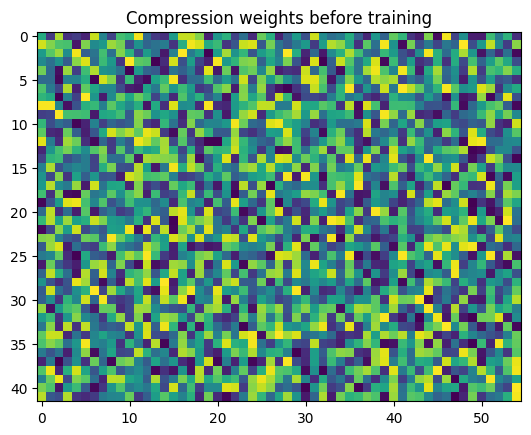

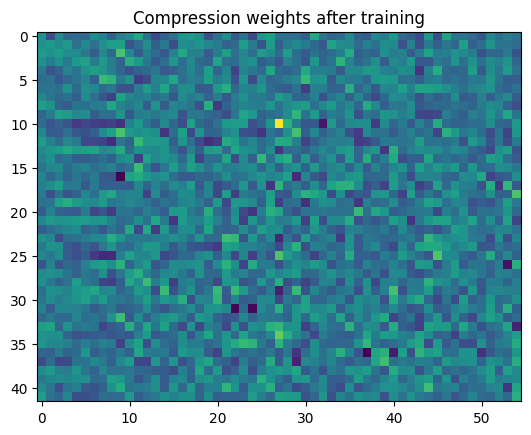

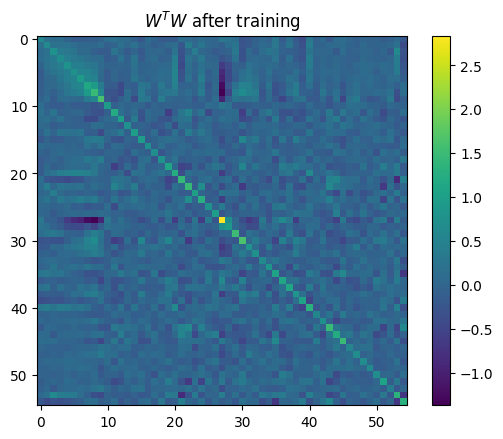

In [265]:
diff_weights = pre_training_weight - post_training_weight
plt.imshow(to_numpy(pre_training_weight))
plt.title("Compression weights before training")
plt.show()
plt.imshow(to_numpy(post_training_weight))
plt.title("Compression weights after training")
plt.show()
plt.imshow(to_numpy(post_training_weight.T) @ to_numpy(post_training_weight))
plt.title("$W^T W$ after training")
plt.colorbar()
plt.show()

In [4]:
reload_fuctions()

models = [model, model_mid_decay, model_high_decay, assembled_model]
model_names = ['Model:\t\t', 'Model 0.01 decay:', 'Model 0.1 decay:','Tracr model:\t']
input_size = 10
x,y = generate_data(1, len(vocab), input_size)
print('Data in:\t\t', x.squeeze().tolist())
print('Data out:\t\t', y.squeeze().tolist())

for i, mod in enumerate(models):
    pred = prompt(mod, x)
    print(f'{model_names[i]}\t', pred)

Data in:		 [6, 9, 8, 8, 4, 4, 0, 3, 2, 3]
Data out:		 [0, 2, 3, 3, 4, 4, 6, 8, 8, 9]
Model:			 [0, 2, 3, 3, 4, 4, 6, 8, 8, 9]
Model 0.01 decay:	 [0, 2, 3, 3, 4, 4, 6, 8, 8, 9]
Model 0.1 decay:	 [0, 2, 3, 3, 4, 4, 6, 8, 8, 9]
Tracr model:		 [0, 2, 3, 3, 4, 3, 6, 8, 9, 9]


In [5]:
reload_fuctions()
assembled_logits, assembled_cache = run_with_activations(assembled_model, x)
trained_logits, trained_cache = run_with_activations(model, x)
trained_mid_decay_logits, trained_mid_decay_cache = run_with_activations(model_mid_decay, x)
trained_high_decay_logits, trained_high_decay_cache = run_with_activations(model_high_decay, x)
tracr_logits, tracr_cache = run_with_activations(tr_model, x, INPUT_ENCODER)

## Tracr Transformer output reference:
| Activation      | Dimension                          |
|-----------------|------------------------------------|
| layer_outputs   | [Batch, Sequence_Size, d_embedding]|
| residuals       | [Batch, Sequence_Size, d_embedding]|
| attn_logits     | [Batch, n_heads, Sequence_Size, Sequence_Size]|
| output          | [Batch, Sequence_Size, d_embedding]|
| input_embeddings| [Batch, Sequence_size, d_embedding]|

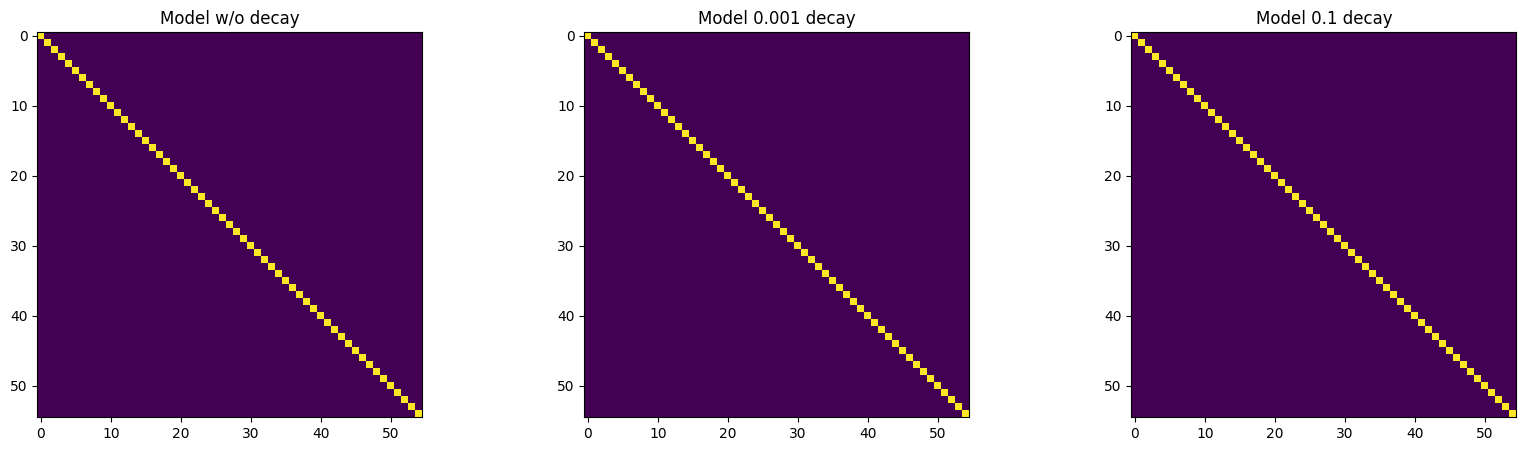

In [76]:
reload_fuctions()
compression_hooks = [m.compression.weight for m in [model, model_mid_decay, model_high_decay]]
compression_hook_names = ['Model w/o decay', 'Model 0.001 decay', 'Model 0.1 decay']

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, hook in enumerate(compression_hooks):
    axs[i].imshow(to_numpy(hook))
    axs[i].set_title(compression_hook_names[i])

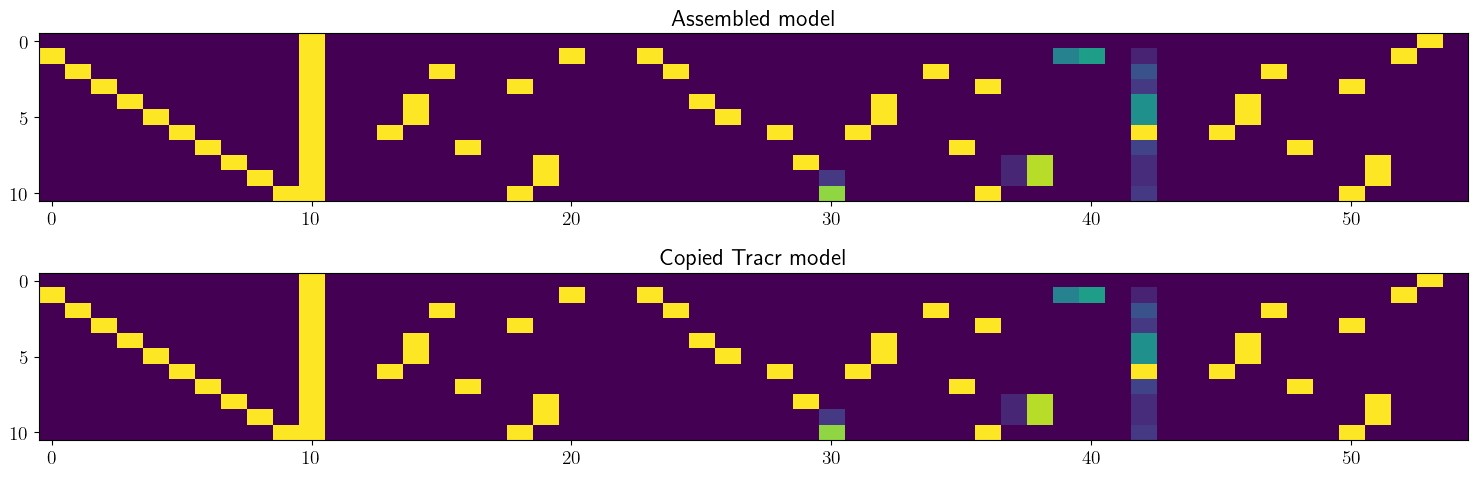

In [9]:
copied_out = to_numpy(tracr_cache['blocks.2.hook_resid_post']).squeeze()
assembled_out = assembled_cache.transformer_output.squeeze()

fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].imshow(assembled_out, aspect='auto')
ax[0].set_title('Assembled model')
ax[1].imshow(copied_out, aspect='auto')
ax[1].set_title('Copied Tracr model')
plt.tight_layout()
plt.show()

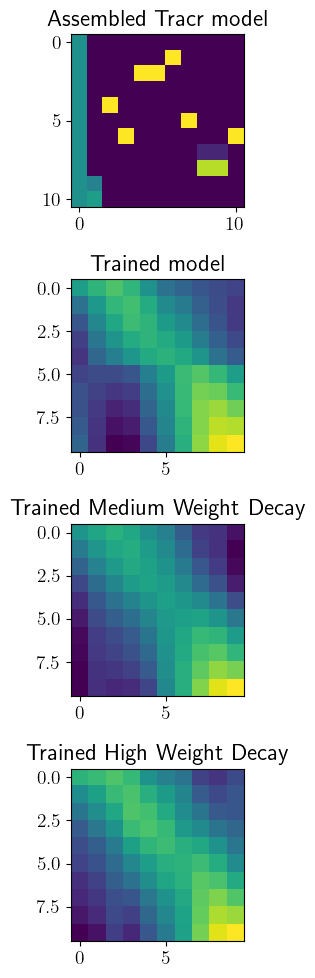

In [10]:
reload_fuctions()
logits = [
    np.array(assembled_logits[-1]),
    to_numpy(trained_logits),
    to_numpy(trained_mid_decay_logits),
    to_numpy(trained_high_decay_logits),
]

plot_activations(["Assembled Tracr model", "Trained model", "Trained Medium Weight Decay", "Trained High Weight Decay"], *logits)

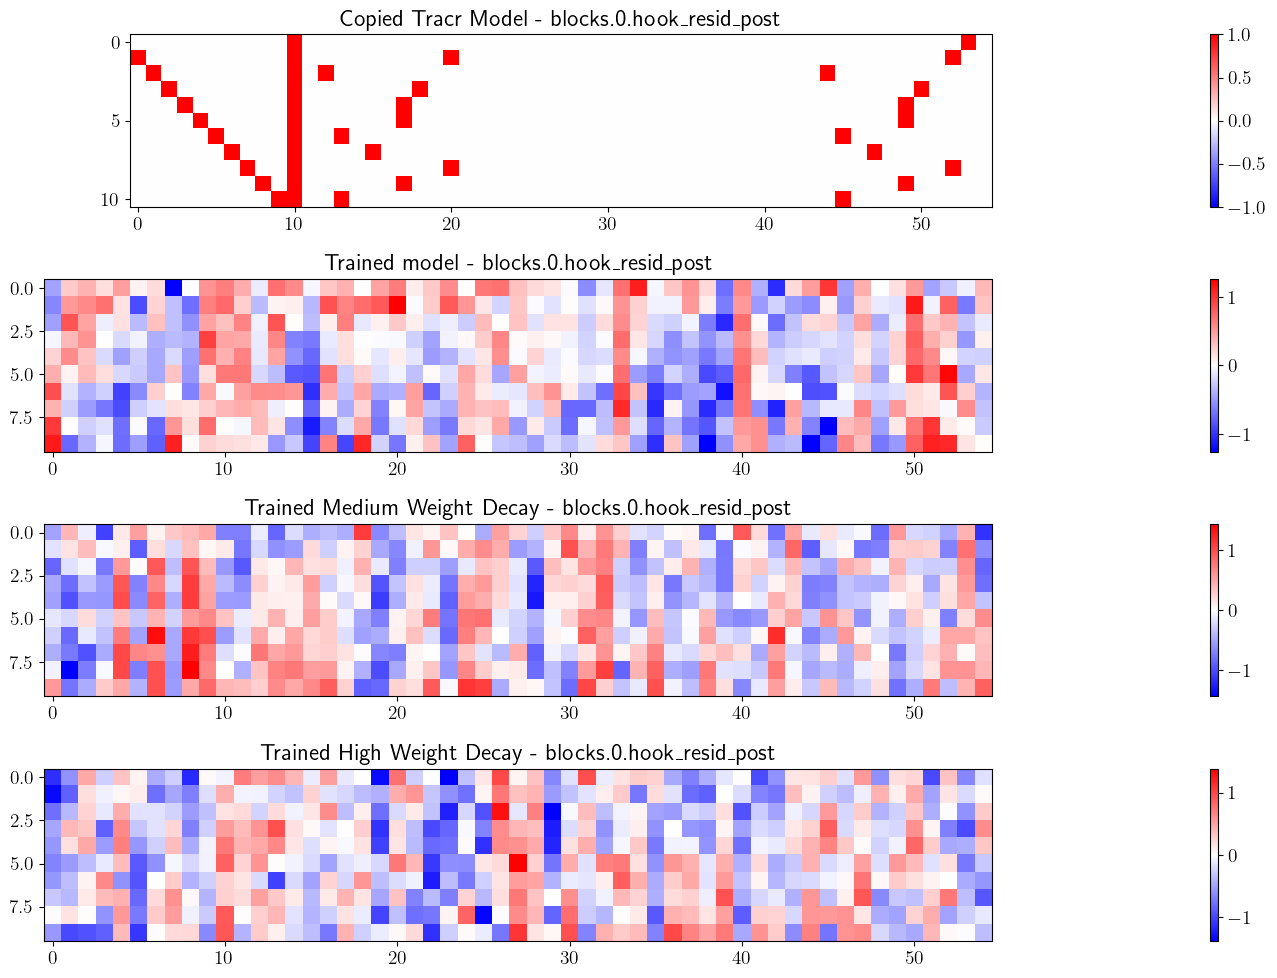

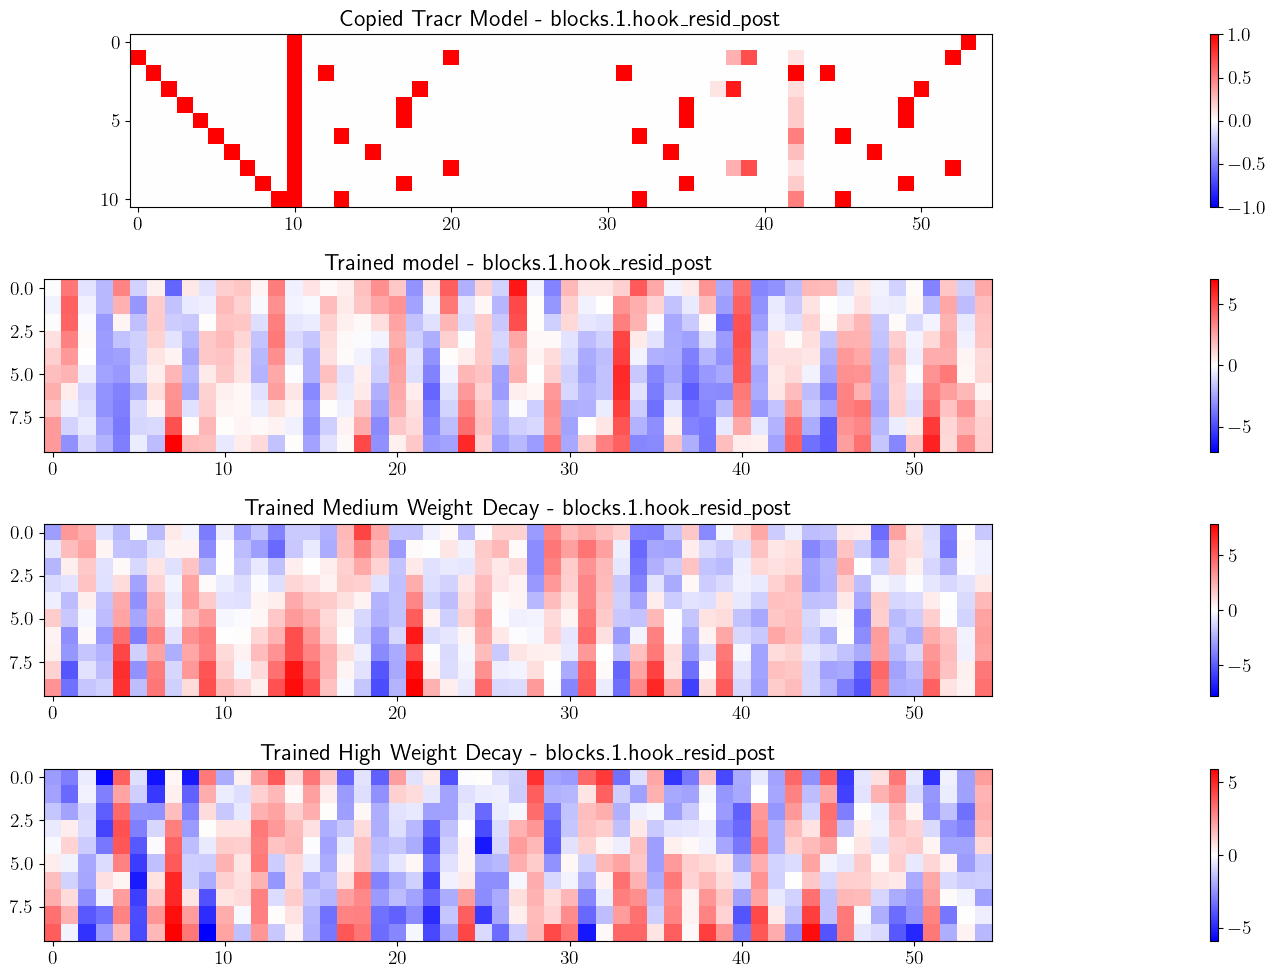

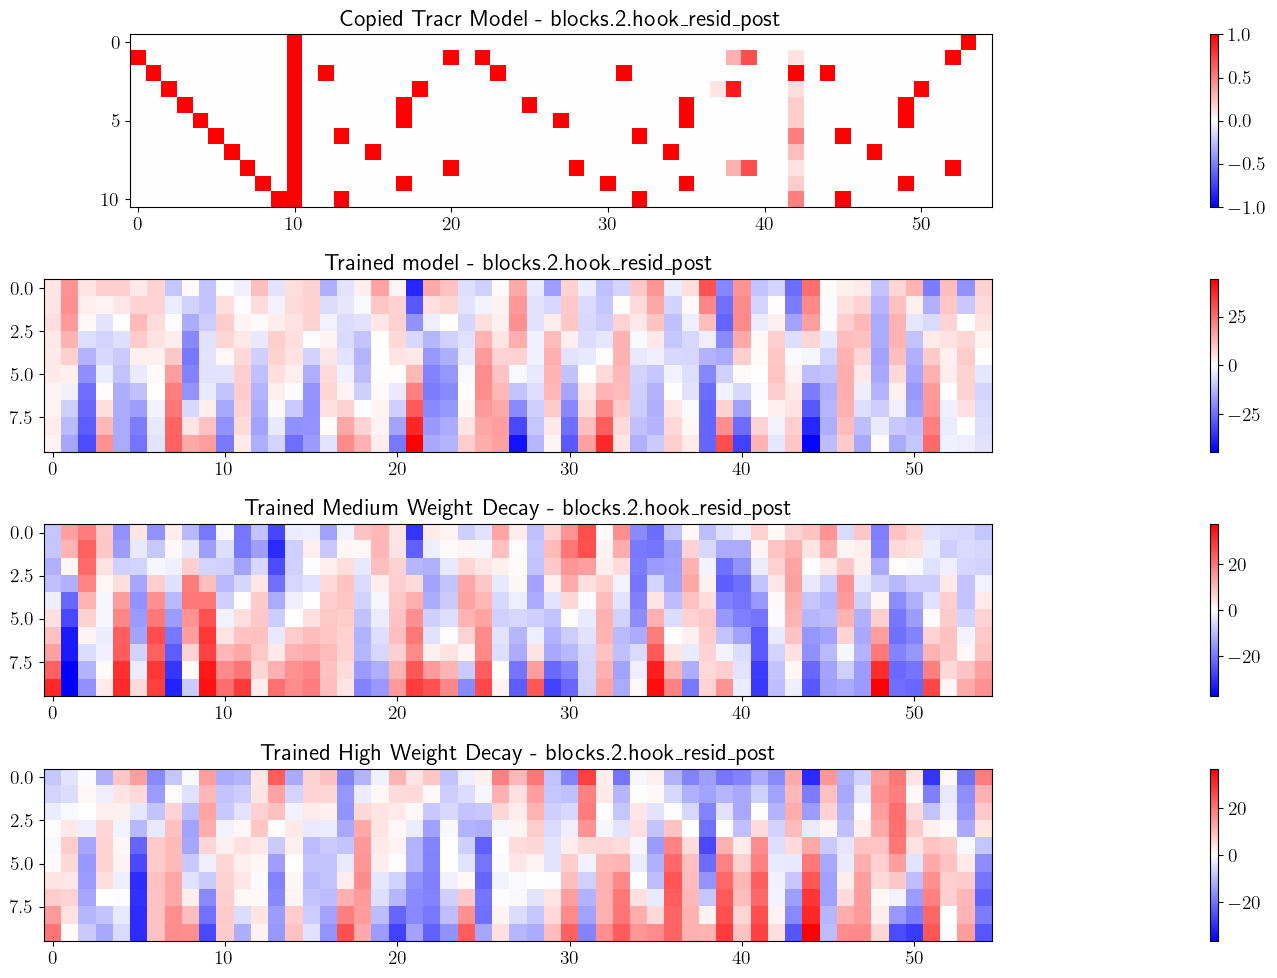

In [40]:
reload_fuctions()
act_caches = [cache.items() for cache in [tracr_cache, trained_cache, trained_mid_decay_cache, trained_high_decay_cache]]
act_zipped = [*zip(*act_caches)]
resid_labels = ['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post']

# Filter activations with the specific name
filtered_activations = [list(filter(lambda x: x[0] in resid_labels, activations)) for activations in act_zipped]
filtered_activations = [activations for activations in filtered_activations if activations]

labels = ["Copied Tracr Model", "Trained model", "Trained Medium Weight Decay", "Trained High Weight Decay"]

for i, activations in enumerate(filtered_activations):
    plot_activations(
        [f"{labels[i]} - {activations[i][0]}" for i in range(len(activations))],
        *[to_numpy(activation[1]) for activation in activations ]
    )


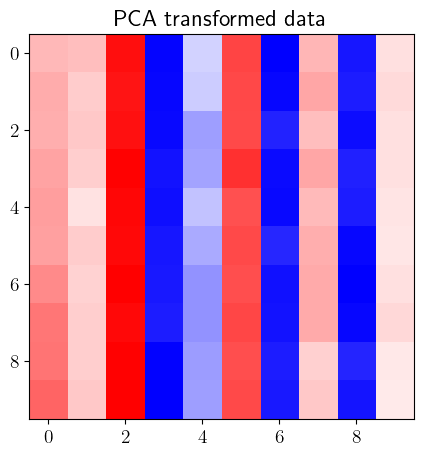

In [14]:
# import PCA lib
from sklearn.decomposition import PCA

# Create a PCA model
pca = PCA(n_components=10)

# Fit the PCA model to the data
pca.fit(to_numpy(trained_cache['blocks.2.hook_resid_post']).squeeze())

# Get the transformed data
pca_data = pca.transform(to_numpy(trained_cache['blocks.0.hook_resid_post']).squeeze())

# Plot the transformed data
plt.imshow(pca_data)
plt.title('PCA transformed data')
plt.show()

## Activation patching

Activation patching is the process of taking two streams of calculation, one with a 'clean' input and one with a 'corrupted' input, the corrupted input is processed in the model, but the activations resulting from the clean input are _patched_ in place. This allows for causal inference on the changes in the activations due to the corrupted input.

> Mechanism:
> - Run clean input through the model
> - Run corrupted input through the model
> - For each activation of interest, replace the corrupted input with the clean input, and calculate the difference in the output

In [4]:
import transformer_lens.patching as patching
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
DO_SLOW_RUNS = True
t.set_grad_enabled(False)

In [5]:
from functools import partial
def logit_difference(logits, logit_corruprted):
    return t.mean(logits - logit_corruprted)


def kl_divergence(logits, logit_corrupted):
    return t.nn.functional.kl_div(t.nn.functional.log_softmax(logits, dim=1), t.nn.functional.softmax(logit_corrupted, dim=1))


def patch(model, tokens_corrupt, tokens_clean, measure, patching):
    logits, acti = run_with_activations(model, tokens_clean)
    divergence = partial(measure, logits)
    return patching(model, tokens_corrupt, acti, divergence)
    

def plot(patch, title):
    max_abs_value = t.max(t.abs(patch)).item()
    plt.imshow(to_numpy(patch).squeeze(), vmax=max_abs_value, vmin=-max_abs_value)
    plt.title(title)
    plt.xlabel('Token index')
    plt.ylabel('Layer index')
    plt.colorbar()
    plt.show()

In [29]:
resid_labels = ['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post']

sort_tok = t.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
reverse_tok = sort_tok.flip(0)
reverse_tok[0] = 9
reverse_tok[-1] = 0
all_ones_tok = t.ones(10, dtype=t.long)
all_nines_tok = t.ones(10, dtype=t.long) * 9
scrambled_tok = t.randint(0, 10, (10,))

print('Sort tokens:\t', sort_tok, 'predicted:', prompt(model_high_decay, sort_tok))
print('Reverse tokens:', reverse_tok, 'predicted:', prompt(model_high_decay, reverse_tok))
print('All ones tokens:', all_ones_tok, 'predicted:', prompt(model_high_decay, all_ones_tok))
print('One three tokens:', all_nines_tok, 'predicted:', prompt(model, all_nines_tok))
print('Scrambled tokens:', scrambled_tok, 'predicted:', prompt(model_high_decay, scrambled_tok))

Sort tokens:	 tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) predicted: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Reverse tokens: tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]) predicted: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
All ones tokens: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) predicted: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
One three tokens: tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9]) predicted: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
Scrambled tokens: tensor([4, 3, 8, 3, 5, 1, 7, 0, 0, 0]) predicted: [0, 0, 0, 1, 3, 3, 4, 5, 7, 8]


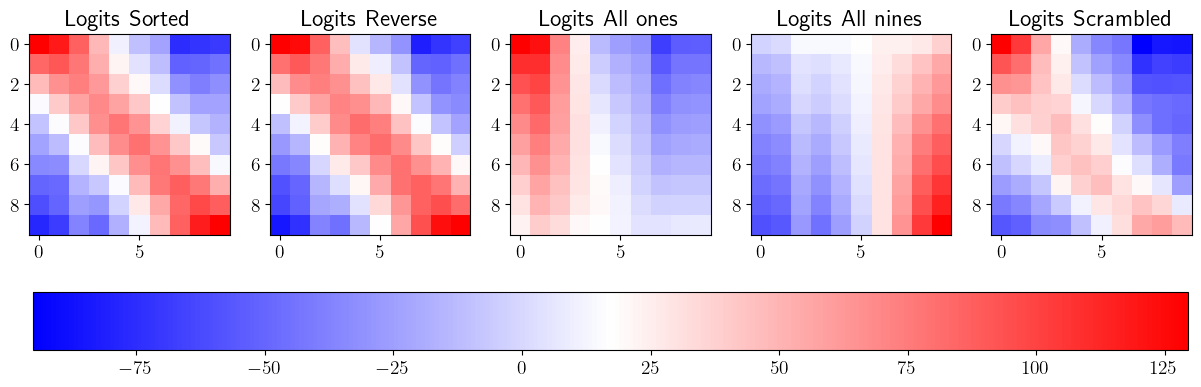

In [30]:
logits_sorted, acti_sorted = run_with_activations(model_high_decay, sort_tok.unsqueeze(0))
logit_reverse, acti_reverse = run_with_activations(model_high_decay, reverse_tok.unsqueeze(0))
logit_ones, acti_ones = run_with_activations(model_high_decay, all_ones_tok.unsqueeze(0))
logit_nine, acti_nine= run_with_activations(model_high_decay, all_nines_tok.unsqueeze(0))
logits_scr, acti_scr  = run_with_activations(model_high_decay, scrambled_tok.unsqueeze(0))

logits = [logits_sorted, logit_reverse, logit_ones, logit_nine, logits_scr]
logit_names = ['Sorted', 'Reverse', 'All ones', 'All nines', 'Scrambled']

fig, axes = plt.subplots(1, len(logits), figsize=(15, 5))
for i, (logit, ax) in enumerate(zip(logits, axes)):
    v_max = t.max(t.abs(logit)).item()
    ax.imshow(to_numpy(logit.squeeze()), vmax=v_max, vmin=-v_max)
    ax.set_title(f'Logits {logit_names[i]}')

# color bar
fig.colorbar(ax.imshow(to_numpy(logit.squeeze())), ax=axes, orientation='horizontal')
plt.show()


In [31]:
from circuitsvis.attention import attention_patterns
from IPython.display import HTML


def vis_attn(cache, tokens):
    for i in range(3):
        attention = to_numpy(cache['pattern', i].squeeze(0))
        tokens = to_numpy(x).squeeze()

        html = attention_patterns(attention, list(map(str, tokens)), f'Layer {i} - {name} tokens')
        display(html)

for tokens, name in zip([sort_tok, reverse_tok, all_ones_tok, all_nines_tok, scrambled_tok], logit_names):

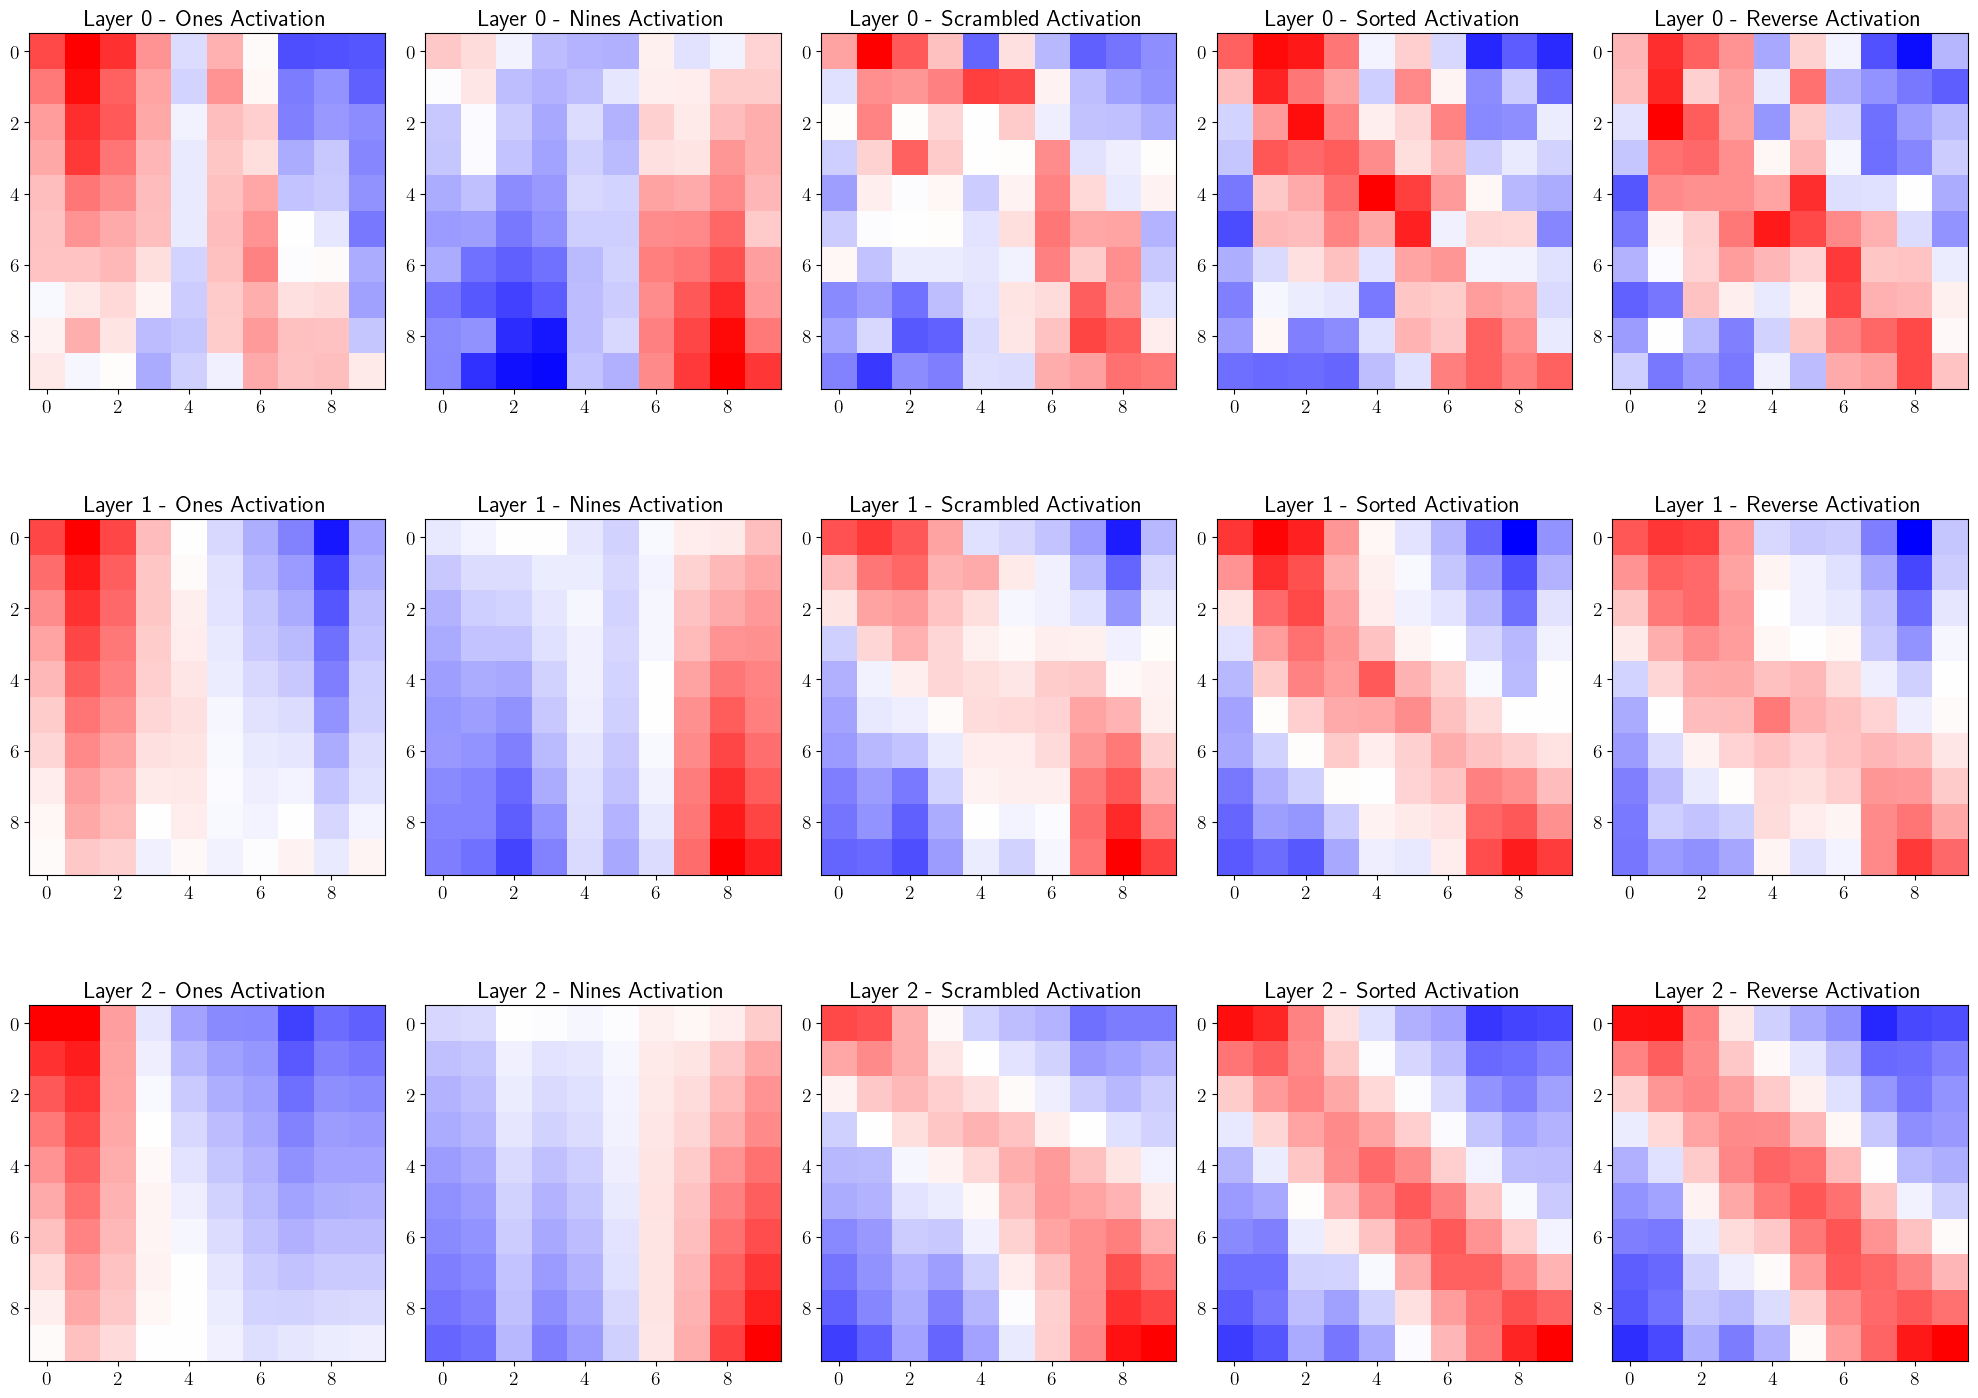

In [10]:
# inspecting the logits at every layer
layers_ones = [model_high_decay.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_ones.items())]
layers_scr= [model_high_decay.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_scr.items())]
layers_srt= [model_high_decay.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_sorted.items())]
layers_reverse= [model_high_decay.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_reverse.items())]
layers_nines= [model_high_decay.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_nine.items())]

activation = ['Ones', 'Nines', 'Scrambled', 'Sorted', 'Reverse']

fig, axs = plt.subplots(3,5,figsize=(20,15))

for i, layer in enumerate(zip(layers_ones, layers_nines, layers_scr, layers_srt, layers_reverse)):
    for j, log in enumerate(layer):
        v_max = t.max(t.abs(log)).item()
        axs[i, j].imshow(to_numpy(log).squeeze(), vmax=v_max, vmin=-v_max)
        axs[i, j].set_title(f'Layer {i} - {activation[j]} Activation')

plt.tight_layout()
plt.show()



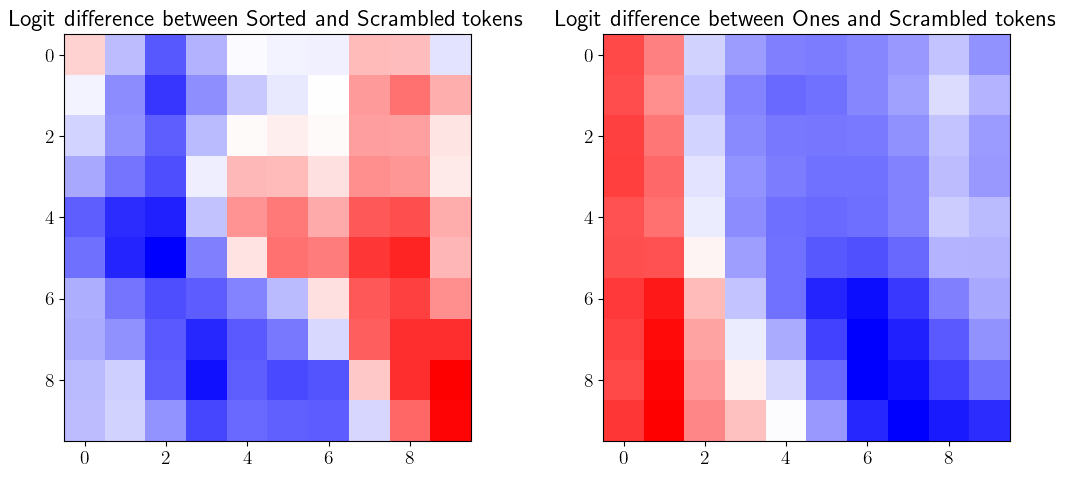

In [20]:
logit_diff_sorted = logits_sorted - logits_scr
logit_diff_ones = logit_ones - logits_scr

plt.subplots(1, 2, figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.imshow(to_numpy(logit_diff_sorted).squeeze())
plt.title('Logit difference between Sorted and Scrambled tokens')

plt.subplot(1, 2, 2)
plt.imshow(to_numpy(logit_diff_ones).squeeze())
plt.title('Logit difference between Ones and Scrambled tokens')

plt.tight_layout()
plt.show()


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

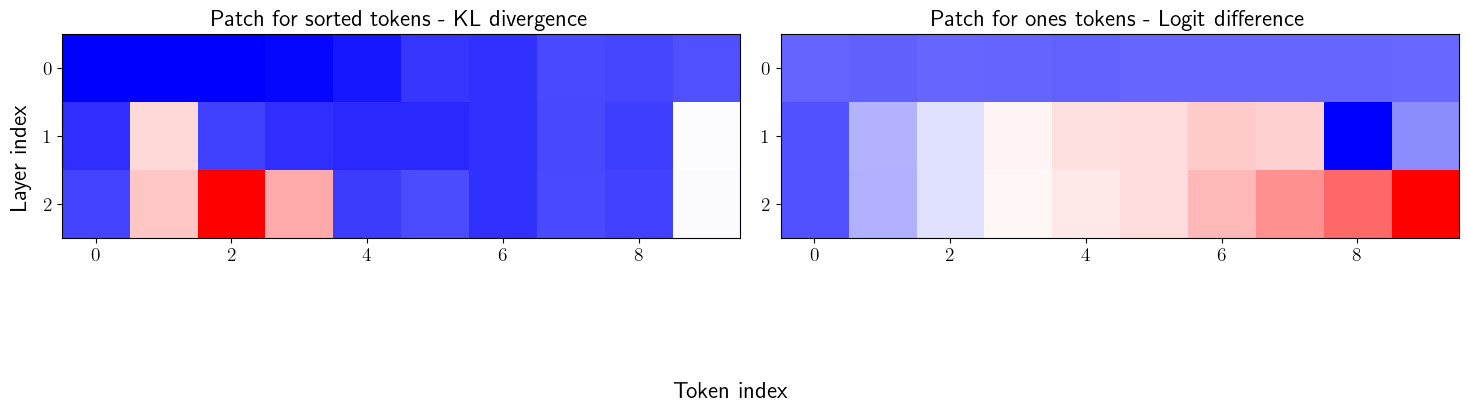

In [27]:
diff_ones = partial(logit_difference, logit_ones)
diff_sorted  = partial(logit_difference, logits_sorted)
diff_reverse = partial(logit_difference, logit_reverse)
diff_scr = partial(logit_difference, logits_scr)

div_ones = partial(kl_divergence, logit_ones)
div_sorted = partial(kl_divergence, logits_sorted)
div_reverse = partial(kl_divergence, logit_reverse)
div_scr = partial(kl_divergence, logits_scr)

# patch_ones_diff = patching.get_act_patch_resid_pre(model_high_decay, all_nines_tok, acti_ones, div_ones)
# patch_sort_diff = patching.get_act_patch_resid_pre(model_high_decay, reverse_tok, acti_sorted, div_sorted) ## Reverse patching -> no change after layer 2, models flips input

# patch_ones_diff = patching.get_act_patch_resid_pre(model_high_decay, all_nines_tok, acti_ones, div_ones)
# patch_ones_diff = patching.get_act_patch_resid_pre(model_high_decay, all_nines_tok, acti_ones, div_ones)

patch_ones_diff = patch(model_high_decay, all_nines_tok, all_ones_tok, kl_divergence, patching.get_act_patch_resid_pre)
patch_sort_diff = patch(model_high_decay, reverse_tok, all_ones_tok , kl_divergence, patching.get_act_patch_resid_pre)


fig, ax = plt.subplots(1,2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(to_numpy(patch_sort_diff).squeeze())
plt.title('Patch for sorted tokens - KL divergence')

plt.subplot(1, 2, 2)
plt.imshow(to_numpy(patch_ones_diff).squeeze())
plt.title('Patch for ones tokens - Logit difference')

# plt.subplot(2, 2, 4)
# plt.imshow(to_numpy(patch_sort_div).squeeze())
# plt.title('Patch for sorted tokens - Logit difference')

fig.supxlabel('Token index')
fig.supylabel('Layer index')
plt.tight_layout()
plt.show()

* Some kind of symmetry
    - There is a flipping mechanism?
    - Some "built-in" thing that causes low values to always have lower logits at high indices and vice versa


  0%|          | 0/30 [00:00<?, ?it/s]

/home/amir/.conda/envs/mech/lib/python3.11/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

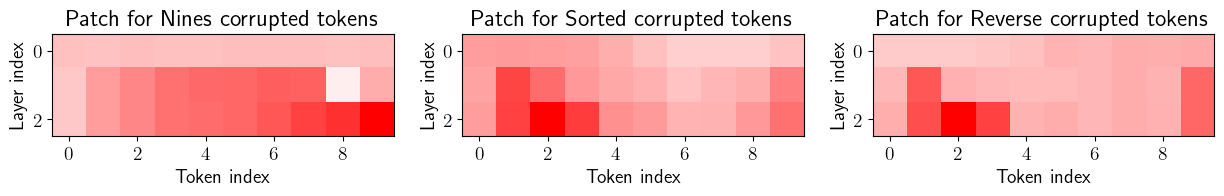

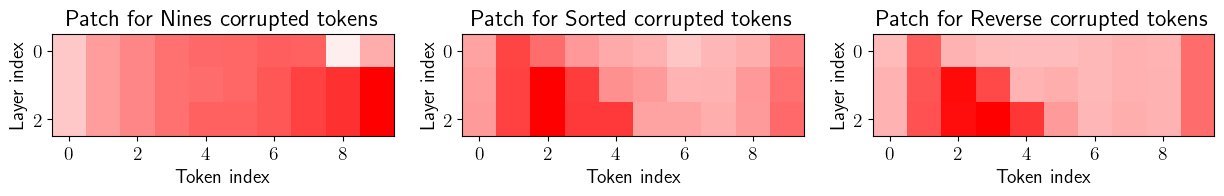

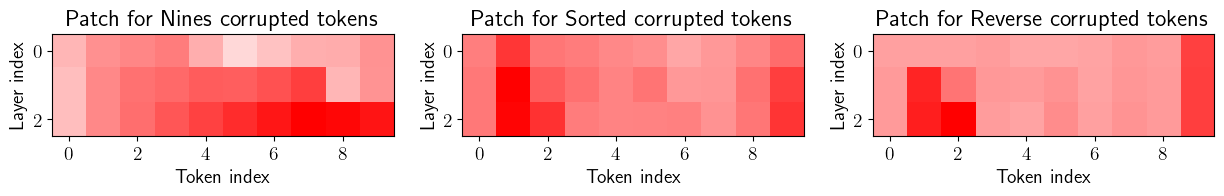

In [12]:
clean_tokens = [all_ones_tok] * 3
corrupted_tokens = [all_nines_tok, sort_tok, reverse_tok]
names = ['Nines', 'Sorted', 'Reverse']

plot_patches(corrupted_tokens, clean_tokens, model_high_decay, kl_divergence, names, patching.get_act_patch_resid_pre)
plot_patches(corrupted_tokens, clean_tokens, model_high_decay, kl_divergence, names, patching.get_act_patch_resid_mid)
plot_patches(corrupted_tokens, clean_tokens, model_high_decay, kl_divergence, names, patching.get_act_patch_mlp_out)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

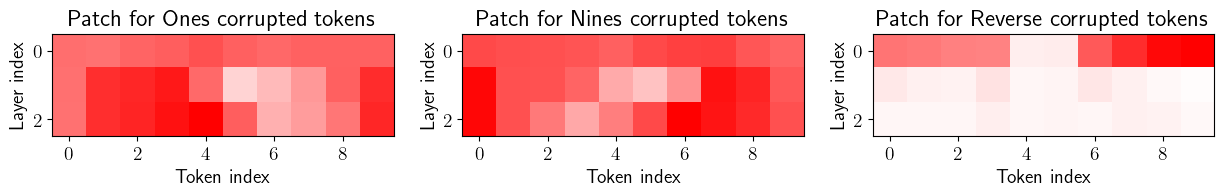

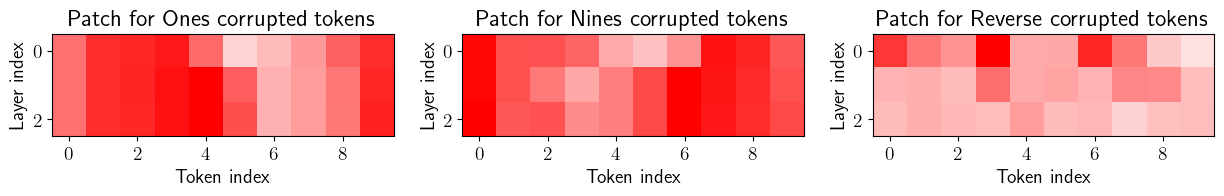

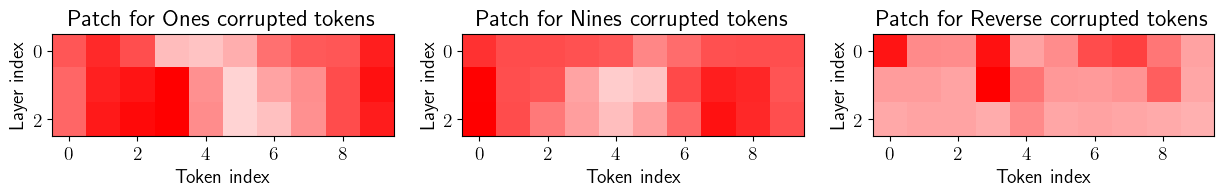

In [13]:
clean_tokens = [sort_tok] * 3
corrupted_tokens = [all_nines_tok, all_ones_tok, reverse_tok]
names = ['Ones', 'Nines', 'Reverse']

plot_patches(corrupted_tokens, clean_tokens, model_high_decay, kl_divergence, names, patching.get_act_patch_resid_pre)
plot_patches(corrupted_tokens, clean_tokens, model_high_decay, kl_divergence, names, patching.get_act_patch_resid_mid)
plot_patches(corrupted_tokens, clean_tokens, model_high_decay, kl_divergence, names, patching.get_act_patch_mlp_out)

# Observations
- Most of the "computation" is done in the first layer, the rest of the layers are just "refining" the output

- When patching the reverse tokens in the first resid, the output logits seem to be flipped, but doing it later does not cause this?

## Experiment 1
How does reversing the input result in reversed output?

- First see how both look in their first layer

### Answer:

- The resid-pre hook, is not the same as the embedding hook, the resid-pre hook is the hook right before the stream "splits" into resid and attn.

In [89]:
def get_layer_1_activations(model, tokens):
    _, cache = run_with_activations(model, tokens)
    layer_1_cache = dict(filter(lambda x: '0' in x[0] or 'embed' in x[0], cache.items()))
    layer_1_cache['logits'] = model_high_decay.unembed(layer_1_cache['blocks.0.hook_resid_post'])
    return layer_1_cache

In [113]:
def label_to_title(label):
    # TODO: Fixed labels, https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/transformer-full-updated.png
    clean_dicts = {
        'resid': 'Residual Stream',
        'mlp': 'MLP',
        'pre': 'Residual Stream before Attention',
        'mid': 'Residual Stream before MLP',
        'post': 'Output',
        'logits': 'Logits',
        'attn': 'Attention',
        'v': 'Value',
        'q': 'Query',
        'k': 'Key',
        'z': 'Hidden State',
        'pattern': 'Attention Pattern',
        'scores': 'Attention Scores',
        'attn_out' : 'Attention Output',
        'mlp_out': 'MLP after Activation Fuction',
        'hook_embed': 'Embedding',
        'hook_pos_embed' : 'Positional Embedding'
    }

    label = label.split('.')
    activation = label[-1]
    activation = activation.split('_')
    if len(label) == 1:
        return clean_dicts.get(label[0], label[0])

    else:
        if activation[-1] == 'out':
            activation_type = clean_dicts.get('_'.join(activation[-2:]), activation[-2:]) 

        else:
            activation_type = clean_dicts.get(activation[-1], activation[-1].capitalize())
        if activation_type == "Output":
            activation_type = clean_dicts.get(activation[-2], 'MLP') + ' ' + activation_type
        if len(label) > 2:
            layer_index = int(label[1]) + 1
            return f"Layer {layer_index} {activation_type}"
        else:
            return f"Layer {activation_type}"

In [132]:
model_high_decay

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-2): 3 x TransformerBlock(
      (ln1): Identity()
      (ln2): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
  (compression): CompressionHook(
  

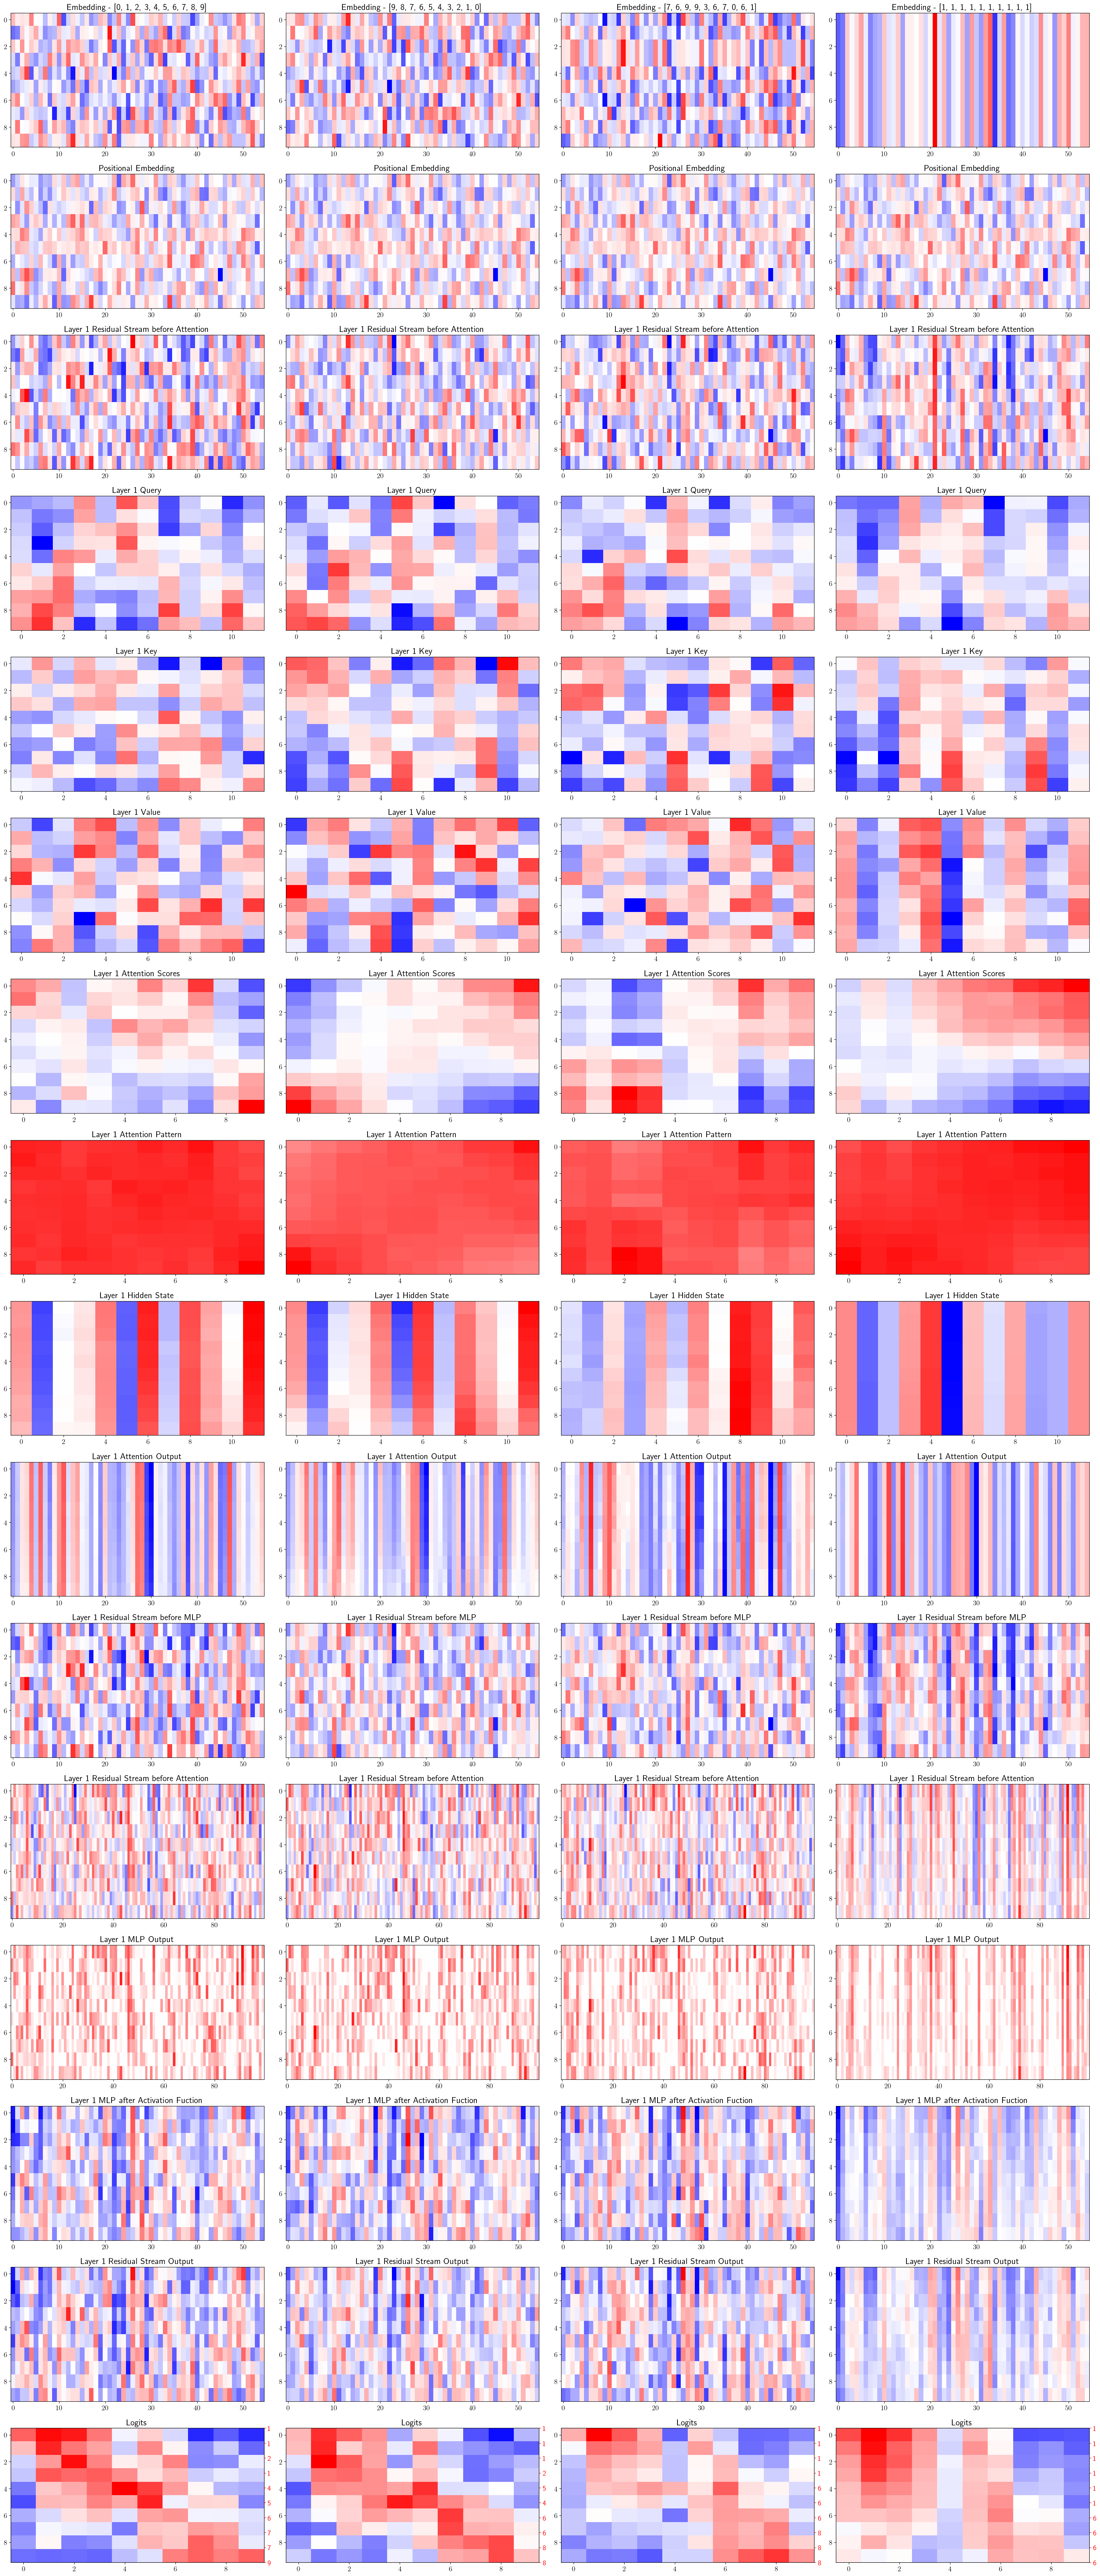

In [115]:
tokens = [sort_tok, reverse_tok, scrambled_tok, all_ones_tok]
caches = map(partial(get_layer_1_activations, model_high_decay), tokens)


fig, axs = plt.subplots(16, len(tokens), figsize=(30, 70))
for i, acts in enumerate(map(lambda x: x.items(), caches)):
    for j, (label, act) in enumerate(acts):
        v_max = t.max(t.abs(act)).item()
        axs[j, i].imshow(to_numpy(act).squeeze(), vmax=v_max, vmin=-v_max, aspect='auto')
        if j == 0:
            axs[j, i].set_title(f'{label_to_title(label)} - {tokens[i].tolist()}')
        else:
            axs[j, i].set_title(label_to_title(label))

        if label == 'logits':
            logt = axs[j,i].twinx()
            logt.set_yticks(range(0, 10, 1))
            logt.set_yticklabels(act.argmax(-1).squeeze().tolist()[::-1], color='red')
            logt.tick_params(axis='y', colors='red')
            logt.set_ylim(0, 9)

plt.tight_layout()
plt.show()

In [131]:
def gen_embedding_dict(model, tokens):
    _, cache = run_with_activations(model, tokens)
    embeddings = to_numpy(cache['hook_embed']).squeeze()
    embedding_dict = {i:embeddings[i,:] for i in range(10)}
    return embedding_dict

positional embedding is constant
